Create a reduced basis for a simple sinusoid model

In [60]:
%matplotlib inline
import numpy as np
from misc import *
import matplotlib.pyplot as plt

Create the signal model:
$h(t) = A\sin{(2\pi(f_0 t + 0.5\dot{f} t^2))}$

In [61]:
def signalmodel(A, f0, f1, t):
  """
  A time domain sinusoid with an amplitude A, frequency f0,
  spin-down f1, evaluated at a set of time stamps t.
  """

  return A*np.sin(2*np.pi*(f0*t + 0.5*f1*t**2))

Initialise the model time series

In [62]:
# a time series
t0 = 0
tend = 86400.*10
N = (tend-t0)/60.
ts = np.linspace(t0, tend, N)
dt = ts[1]-ts[0]

Create a training set of 4000 waveforms with random frequency and frequency derivatives within a narrow range.

In [63]:
# number of training waveforms
TS_size = 4000
#f0s = np.random.rand(TS_size)*0.0002-0.0001
# set f0s using Chebyshev-Gauss-Lobatto nodes
f0s, df0s = chebyshev_gauss_lobatto_nodes_and_weights(-0.0001, 0.0001, TS_size)
f1s = np.random.rand(TS_size)*(2e-10)-1e-10

# allocate memory and create training set
TS = np.zeros(TS_size*len(ts)).reshape(TS_size, len(ts)) # store training space in TS_size X len(ts) array
A = 1.

for i in range(TS_size):
  TS[i] = signalmodel(A, f0s[i], f1s[i], ts)
  
  # normalize
  TS[i] /= np.sqrt(abs(dot_product(dt, TS[i], TS[i])))

Allocate memory for reduced basis vectors.

In [64]:
# Allocate storage for projection coefficients of training space waveforms onto the reduced basis elements
proj_coefficients = np.zeros(TS_size*TS_size).reshape(TS_size, TS_size)

# Allocate matrix to store the projection of training space waveforms onto the reduced basis 
projections = np.zeros(TS_size*len(ts)).reshape(TS_size, len(ts)) 

rb_errors = []

#### Begin greedy: see Field et al. arXiv:1308.3565v2 #### 

tolerance = 10e-12 # set maximum RB projection error

sigma = 1 # (2) of Algorithm 1. (projection error at 0th iteration)

rb_errors.append(sigma)

Run greedy algorithm for creating the reduced basis

In [65]:
RB_matrix = [TS[0]] # (3) of Algorithm 1. (seed greedy algorithm (arbitrary))

iter = 0

while sigma >= tolerance: # (5) of Algorithm 1.
  # project the whole training set onto the reduced basis set
  projections = project_onto_basis(dt, RB_matrix, TS, projections, proj_coefficients, iter) 

  residual = TS - projections
  # Find projection errors
  projection_errors = [dot_product(dt, residual[i], residual[i]) for i in range(len(residual))]
        
  sigma = abs(max(projection_errors)) # (7) of Algorithm 1. (Find largest projection error)
  
  # break out if sigma is less than tolerance, so another basis is not added to the set
  # (this can be required is the waveform only requires a couple of basis vectors, and it
  # stops a further basis containing large amounts of numerical noise being added)
  if sigma < tolerance:
    break
        
  print sigma, iter
  index = np.argmax(projection_errors) # Find Training-space index of waveform with largest proj. error 

  rb_errors.append(sigma)
    
  #Gram-Schmidt to get the next basis and normalize

  next_basis = TS[index] - projections[index] # (9) of Algorithm 1. (Gram-Schmidt)
  next_basis /= np.sqrt(abs(dot_product(dt, next_basis, next_basis))) #(10) of Alg 1. (normalize)

  RB_matrix.append(next_basis) # (11) of Algorithm 1. (append reduced basis set)

  iter += 1

0.99999999999 0
0.99999990277 1
0.999996644676 2
0.999979417867 3
0.999965803654 4
0.999933093327 5
0.999909303977 6
0.999593010112 7
0.999140471856 8
0.999039817303 9
0.998344774353 10
0.998230183312 11
0.997863589898 12
0.996957653635 13
0.99650603249 14
0.995519946907 15
0.994919375845 16
0.994356720926 17
0.994079317576 18
0.993942700333 19
0.993455505349 20
0.992643967564 21
0.989898343264 22
0.989309915135 23
0.988149872912 24
0.985979095682 25
0.983845035532 26
0.982985539555 27
0.980815790277 28
0.979892126155 29
0.978288348946 30
0.97632881251 31
0.973135555144 32
0.972962899625 33
0.972583071519 34
0.969516235548 35
0.966368374464 36
0.966164200946 37
0.965309812003 38
0.962682324556 39
0.961457495891 40
0.960014740499 41
0.957804590473 42
0.957699546094 43
0.955573280726 44
0.952535225359 45
0.95118595881 46
0.94664491438 47
0.942707596838 48
0.939540696349 49
0.935199352414 50
0.933113296096 51
0.930508978834 52
0.928242636677 53
0.925963032671 54
0.923963765328 55
0.922750

Check that this basis does give the expected residuals for a new set of random waveforms generated from the same parameter range.

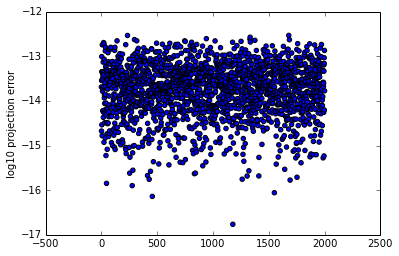

In [66]:
#### Error check ####

TS_rand_size = 2000

TS_rand = np.zeros(TS_rand_size*len(ts)).reshape(TS_rand_size, len(ts)) # Allocate random training space

f0s_rand = np.random.rand(TS_rand_size)*0.0002-0.0001
f1s_rand = np.random.rand(TS_rand_size)*(2e-10)-1e-10

for i in range(TS_rand_size):
  TS_rand[i] = signalmodel(A, f0s_rand[i], f1s_rand[i], ts)
  # normalize
  TS_rand[i] /= np.sqrt(abs(dot_product(dt, TS_rand[i], TS_rand[i])))


### find projection errors ###
iter = 0
proj_rand = np.zeros(len(ts))
proj_error = []

for h in TS_rand:
  while iter < len(RB_matrix):
    proj_coefficients_rand = dot_product(dt, RB_matrix[iter], h)
    proj_rand += proj_coefficients_rand*RB_matrix[iter]

    iter += 1

  residual = h - proj_rand
  projection_errors = abs(dot_product(dt, residual, residual))
  proj_error.append(projection_errors)
  proj_rand = np.zeros(len(ts))

  iter = 0
        
plt.scatter(np.linspace(0, len(proj_error), len(proj_error)), np.log10(proj_error))
plt.ylabel('log10 projection error')
plt.show()

Now let's try and find an empirical interpolant and set of time stamps.

In [67]:
# put basis into complex form
e = np.array(RB_matrix)

indices = []
ts_nodes = []
V = np.zeros((len(e), len(e)))

Find emipirical interpolant

In [68]:
from scipy.linalg import inv

# seed EIM algorithm

indices.append( int(np.argmax( np.abs(e[0]) )) ) # (2) of Algorithm 2
ts_nodes.append(ts[indices[0]]) # (3) of Algorithm 2

for i in range(1, len(e)): #(4) of Algorithm 2
  #build empirical interpolant for e_iter
  for j in range(len(indices)): # Part of (5) of Algorithm 2: making V_{ij} 
    for k in range(len(indices)): # Part of (5) of Algorithm 2: making V_{ij} 
      V[k][j] = e[j][indices[k]] # Part of (5) of Algorithm 2: making V_{ij} 
  invV = inv(V[0:len(indices), 0:len(indices)]) # Part of (5) of Algorithm 2: making V_{ij} 
  B = B_matrix(invV, e) # Part of (5) of Algorithm 2: making B_j(f)
  interpolant = emp_interp(B, e[i], indices) # Part of (5) of Algorithm 2: making the empirical interpolant of e
  res = interpolant - e[i] # 6 of Algorithm 2

  index = int(np.argmax(np.abs(res))) # 7 of Algorithm 2
  print "ts{%i} = %f"%(i, ts[index])
  indices.append(index) # 8 of Algorithm 2
  ts_nodes.append( ts[index] ) # 9 of Algorithm 2
        
# make B matrix with all the indices
for j in range(len(indices)):
  for k in range(len(indices)):
    V[k][j] = e[j][indices[k]]

invV = inv(V[0:len(indices), 0:len(indices)])
B = B_matrix(invV, e)

ts{1} = 307401.347316
ts{2} = 824877.283145
ts{3} = 555818.598514
ts{4} = 111907.771373
ts{5} = 855659.420793
ts{6} = 36962.566845
ts{7} = 335603.305785
ts{8} = 368305.576776
ts{9} = 600641.711230
ts{10} = 347004.097507
ts{11} = 210194.596847
ts{12} = 383726.647684
ts{13} = 84305.854573
ts{14} = 525216.473366
ts{15} = 252557.538718
ts{16} = 421649.281200
ts{17} = 397647.614418
ts{18} = 175392.180013
ts{19} = 432990.068755
ts{20} = 700608.653379
ts{21} = 634244.044725
ts{22} = 494854.364886
ts{23} = 718369.886798
ts{24} = 22801.583443
ts{25} = 663106.049031
ts{26} = 784014.445448
ts{27} = 750952.149455
ts{28} = 639824.432252
ts{29} = 512915.619140
ts{30} = 124028.613098
ts{31} = 580480.311133
ts{32} = 373405.930967
ts{33} = 331883.047434
ts{34} = 520956.177512
ts{35} = 279619.418015
ts{36} = 802675.741371
ts{37} = 575559.969442
ts{38} = 460771.998055
ts{39} = 481833.460657
ts{40} = 302240.988958
ts{41} = 417028.960344
ts{42} = 103387.179665
ts{43} = 446431.002153
ts{44} = 157390.929926


Let's compare a random waveform and it's equivalent interpolant for comparison.

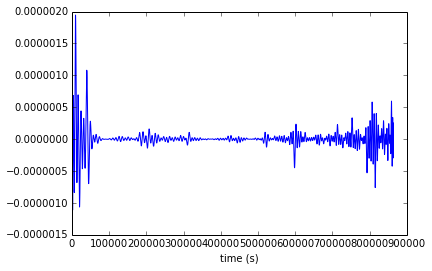

In [69]:
h_for_comparison = signalmodel(A, f0s_rand[10], f1s_rand[10], ts)
interpolant_for_comparison = np.inner(B.T, h_for_comparison[indices])

plt.plot(ts, h_for_comparison-interpolant_for_comparison, 'b')
plt.xlabel('time (s)')
plt.show()

Now let's create a set of random waveforms from within the parameter ranges and further compare errors between the full waveform and interpolant.

2.33163459545e-13
1.48865407677e-13
4.22442989781e-14
2.94179546504e-15
3.03968007273e-14
1.03892715929e-13
1.39447767676e-13
1.09870700833e-13
8.55007663904e-13
4.01387106948e-13
7.25698921772e-14
1.62005406899e-13
1.08141397215e-14
1.47053760855e-13
3.85836878408e-14
2.76744685793e-13
9.30808552947e-14
2.48290844577e-13
2.94857037789e-13
1.14190919402e-13
1.77731443481e-13
2.05017271094e-13
5.49413240383e-15
2.3613532287e-14
3.09982087516e-14
7.21240776446e-13
2.25452890122e-14
2.90027371313e-14
1.35689473844e-13
5.58049977998e-13
1.8061009714e-15
2.87680421627e-14
6.1613917191e-14
1.7805602362e-13
1.11768074387e-14
2.42763051747e-14
4.3210135759e-14
1.33888145144e-13
1.09463100577e-13
3.45246308476e-13
2.20724738322e-13
6.36352206031e-14
1.27078326804e-13
1.62627484053e-15
1.56672286849e-14
1.02616020612e-13
7.98077648864e-15
1.55946378716e-13
1.62084088989e-14
4.62265370019e-13
2.5911261153e-13
3.28458098338e-13
9.57536860066e-14
3.37926594193e-13
2.51712099937e-14
3.55722799432e-1

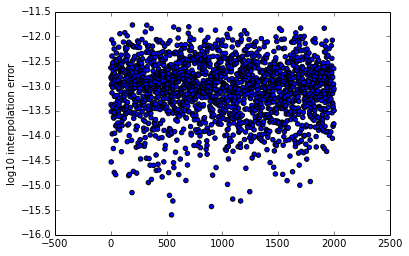

In [70]:
H_size = 2000

H = np.zeros(H_size*len(ts)).reshape(H_size, len(ts)) # Allocate random training space

f0s_rand = np.random.rand(H_size)*0.0002-0.0001
f1s_rand = np.random.rand(H_size)*(2e-10)-1e-10

# create set of test waveforms
for i in range(H_size):
  H[i] = signalmodel(A, f0s_rand[i], f1s_rand[i], ts)

# find errors between full waveform and interpolants
list_of_errors = []
for i in range(H_size):
  interpolant = np.inner(B.T, H[i][indices])
  interpolant /= np.sqrt(np.vdot(interpolant, interpolant)) #normalize

  H[i] /= np.sqrt(np.vdot(H[i], H[i]) ) #normalize
        
  error = abs(np.vdot(H[i] - interpolant, H[i] - interpolant ))
  list_of_errors.append(error)

  print error
        
plt.scatter(np.linspace(0, H_size, H_size), np.log10(list_of_errors))
plt.ylabel('log10 interpolation error')
plt.show()

Create weights for data-model terms and model-model terms

In [71]:
data = np.random.randn(len(ts))

# create weights for data-model terms of interpolant
w = np.inner(B, data.T)

# create weights model-model terms of interpolant
w2 = np.zeros((B.shape[0], B.shape[0]))
for i in range(B.shape[0]):
  for j in range(B.shape[0]):
    w2[i,j] = np.sum(B[i]*B[j])

Now do some accuracy tests

In [73]:
sigfull = signalmodel(A, f0s_rand[23], f1s_rand[23], ts)

tsred = np.array(ts_nodes)
sigred = signalmodel(A, f0s_rand[23], f1s_rand[23], tsred)

d_dot_h = np.dot(data, sigfull)
ROQdh = np.dot(w, sigred)

print "regular inner product = %.15e"%d_dot_h
print "ROQ = %.15e"%ROQdh

h_dot_h = np.dot(sigfull, sigfull)
ROQh = np.dot(np.dot(sigred, w2), sigred)

print "regular inner product = %.15e"%h_dot_h
print "ROQ = %.15e"%ROQh

regular inner product = -3.215918066058420e+01
ROQ = -3.215918223925058e+01
regular inner product = 7.193892717132151e+03
ROQ = 7.193892607175362e+03


Now do a speed test

In [74]:
import time

t1 = time.time()
for i in range(50000):
    sigfullnew = signalmodel(A, f0s_rand[0], f1s_rand[0], ts)
    dms = data-sigfullnew
    np.dot(dms, dms) # regular inner product
e1 = time.time()

t2 = time.time()
for i in range(50000):
    sigrednew = signalmodel(A, f0s_rand[0], f1s_rand[0], tsred)
    np.dot(w, sigred)
    np.dot(np.dot(sigrednew, w2), sigrednew) # ROQ inner product
e2 = time.time()

print "regular inner product took %f s"%((e1-t1)/50000.)
print "ROQ took %f s"%((e2-t2)/50000.)
print "speedup = %f"%((e1-t1) / (e2-t2))

regular inner product took 0.000491 s
ROQ took 0.000039 s
speedup = 12.544360


In [59]:
print float(len(ts))/float(len(tsred))

54.9618320611
